In [ ]:
# snapshots pickles need to be inside folder "snapshots" in relation to this file's folder.
# auxiliary file "mor_fcts.py" needs to be in the same folder as this file/notebook.

In [1]:
run_mode = "colab" # choose "colab" or "local"
colab_directory = '/content/drive/MyDrive/turbi' # Snapshot pickle files need to be inside folder "snapshots" inside this folder

# Loading data and returns the stacked snapshot matrix of all parameters:
type_data = "full"  # choose: "reduced" or "full"

# Loads each of the snapshot matrices (for each parameter) or the saved stacked version:
load_format = "stacked" # choose "each" or "stacked"


In [2]:
# Loads auxiliary functions from file mor_fcts.py:

if run_mode == "colab":
  # mount colab drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Load functions from mor_fcts.py file
  import sys
  sys.path.append(colab_directory)
  from mor_fcts import *
else:
  from mor_fcts import *


Mounted at /content/drive


In [ ]:
# Passo 0 - Carregar Dados de Alta Fidelidade - Para Treino e Validação.
# Step 0 - Load high fidelity data - For Training and Validation.
S_train, S_val = load_high_fidelity_data_fct(
                                            mode = run_mode,
                                            data = type_data,
                                            format = load_format,
                                            colab_dir = colab_directory,
                                            )

The shape of S_train is:  (70801, 1074)
The shape of S_val is:  (70801, 179)


In [ ]:
# Passo 1 - Normalização Dados Treino.
# Step 1 - Normalization of Training Data.
min_Strain = np.min(S_train)
max_Strain = np.max(S_train)
Strain_norm = (S_train - min_Strain) / (max_Strain - min_Strain)

In [ ]:
# Verificando Normalização Passo 1 foi feita corretamente.
# Checking Normalization of Step 1 was successful.
print(Strain_norm.min())
print(Strain_norm.max())

0.0
1.0


Explained Variance Ratio (EVR) [4.00318744e-01 3.10022004e-01 1.39360841e-01 ... 1.94054773e-23
 1.41897918e-23 2.95382251e-24]
Cum_sum EVR [0.40031874 0.71034075 0.84970159 ... 1.         1.         1.        ]
Sum EVR 1.0000000000003744
Singular Values [1.27405261e+03 1.03600703e+03 7.01266654e+02 ... 8.18682126e-09
 7.00071752e-09 3.19408355e-09]


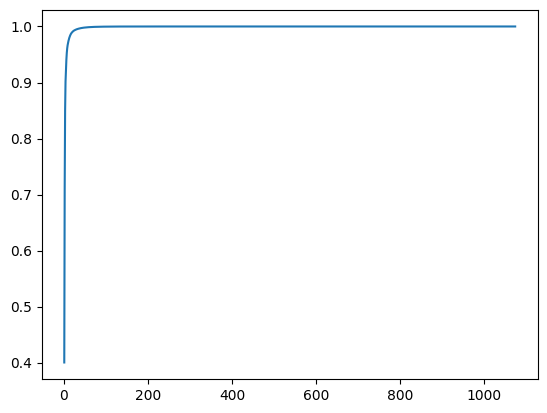

In [ ]:
# @title
# (---WARNING --- this is slow)
# Performs SVD via Scikit learn
# In colab, it takes about (it stops because it takes too long).... for the "full data".
# It is used to generate a plot of explained variance versus number of modes.
# This is not necessary to calculate u_pod solution (ahead). So, you may skip this cell.


# if type_data == "reduced":
#   dim_svd = S_train.shape[1]
# elif type_data = "full":
#   dim_svd = S_train.shape[1]
# else:
#   print("Choose the appropriate value for 'type_data'.")

dim_svd = S_train.shape[1]

svd_S = svd_sklearn(S_train, dim_svd) # svd_sklearn is a fct in the aux. file.

ev_cum_sum = explain_var(svd_S, print_EV=True, plot=True) # explain_var is a fct in the aux. file.
import pickle
# Save the predicted numpy array with Pickle
with open("/content/drive/MyDrive/turbi/" + "ev_cum_sum.pkl", 'wb') as f:
    pickle.dump(ev_cum_sum, f)

In [ ]:
# Passo 2 - Realizar Decomposição em Valores Singulares
# Step 2 - Perform Singular Value Decomposition (SVD)

# Cálculo do Posto dos dados de Treino. Necessário mais a frente para definir o número de modos para o valor de erro desejado.
# Calculate rank of Training Data. This is necessary ahead when defining the number of modes for a certain level of prescribed error.

# Calculate rank of S_train
rank_Strain_norm = np.linalg.matrix_rank(Strain_norm, tol=None, hermitian=False)
print("The rank of the snapshot matrix (training data) is: ", rank_Strain_norm)


# Performing SVD:
u, s, vt = svd(Strain_norm)


The rank of the snapshot matrix (training data) is:  1065


In [ ]:
# Passo 3 - Construção de V e uN
# Step 3 - Construction of V and uN

# Goal epsilon (as  last equation of page 4 of paper)
# for eps = 1e-4, N=128=2**7
# for eps = 9.5e-4, N=64
eps = 1.0e-6

# Finding N given epsilon and perform SVD and calculate POD solution or
#  conclude no N exists for the prescribed error:
N = find_N(s, eps)
if N != None:
  print("The number of modes to reach the given error is: ", N)

  if N < rank_Strain_norm:
    # Assembling SVD approximation (to be used as input to autoencoder)
    #  and POD solution.
    # Assembling uN:
    V = u[:,0:N]
    Vt = np.transpose(V)
    uN = np.matmul(Vt,Strain_norm)
    print("The shape of the SVD solution is ", uN.shape)
    print("The shape of the full order solution is: ", S_train.shape)
    u_pod = np.matmul(V,uN)
    print("The shape of the upod solution is: ", u_pod.shape)
    dif_uh_upod = Strain_norm - u_pod
    print("The shape of the diference between high fidelity solution and POD solution is: ", dif_uh_upod.shape)

    print("The maximum absolute error in any point of training is: ", np.array2string(np.max(np.abs(dif_uh_upod)), formatter={'float_kind':'{0:.8f}'.format})  )
    print("The average absolute error in any point of training is: ", np.array2string(np.mean(np.abs(dif_uh_upod)), formatter={'float_kind':'{0:.8f}'.format}) )
    #print("The average absolute error in any point of training is: ", np.mean(np.abs(dif_uh_upod)).round(5) )

  else:# N is larger than rank of S_train:
    print("The choosen N (SVD latent space) for such epsilon is larger or equal to the rank of S_train.")
    print(" You need to redefine epsilon (larger) so that an smaller N is possibly smaller than rank of S_train.")

else:
  print('There is no N that can achieve such epsilon!')


The number of modes to reach the given error is:  270
The shape of the SVD solution is  (270, 1074)
The shape of the full order solution is:  (70801, 1074)
The shape of the upod solution is:  (70801, 1074)
The shape of the diference between high fidelity solution and POD solution is:  (70801, 1074)
The maximum absolute error in any point of training is:  0.01248173
The average absolute error in any point of training is:  0.00005006


In [ ]:
print("Error POD - as equation 4 paper:")
norm_S_train_L1 = np.linalg.norm(Strain_norm, ord=1)
error_POD_L1 = ( np.linalg.norm(dif_uh_upod, ord=1) ) / norm_S_train_L1
print("Matrix error L1 is: ", error_POD_L1.round(5))

norm_S_train_L2 = np.linalg.norm(Strain_norm, ord=2)
error_POD_L2 = ( np.linalg.norm(dif_uh_upod, ord=2) ) / norm_S_train_L2
print("Matrix error L2 is: ", error_POD_L2.round(5))

norm_S_train_Linf = np.linalg.norm(Strain_norm, np.inf)
error_POD_Linf = ( np.linalg.norm(dif_uh_upod, np.inf ) ) / norm_S_train_Linf
print("Matrix error L_infinity is: ", error_POD_Linf.round(5))

Error POD - as equation 4 paper:
Matrix error L1 is:  0.00093
Matrix error L2 is:  0.00023
Matrix error L_infinity is:  0.00212


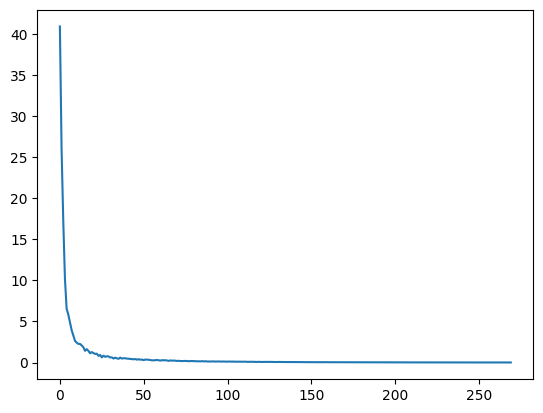

In [ ]:
# Decay of modes
list_avg_abs_mode = []
for i in range(uN.shape[0]):
  list_avg_abs_mode.append(np.mean(np.abs(uN[i])))

plt.plot(list_avg_abs_mode)
plt.show()

In [ ]:
# Passo 4 - Autoencoder:
# Step 4 - Autoencoder:

In [ ]:
# AUTOENCODER - data preparation and batch size definiton:
print("The shape of uN is: ", uN.shape)
print("uN is transposed to be used as input to the autoencoder.")

min_uN = np.min(uN)
max_uN = np.max(uN)
uN_norm = (uN - min_uN) / (max_uN - min_uN)

#uNT = np.transpose(uN)
uNT = np.transpose(uN_norm)

len_temp_param = int(uNT.shape[0]) # needs to take "int" as it is the type pytorch requests.
leng_spatial =int(uNT.shape[1])
print("\nSpatial dimension of entry is: ", leng_spatial)
print("Time versus number of parameters dimension is: ", len_temp_param)

uNT_tensor = torch.tensor(uNT, dtype= torch.float32)
print("The type of input for the AE is: ", type(uNT_tensor), " , and its shape is: ", uNT_tensor.shape)

bt_size = 25
print("\nThe choosen batch size is: ", bt_size)
print("The number of batches is: ", int(len_temp_param/bt_size))

The shape of uN is:  (270, 1074)
uN is transposed to be used as input to the autoencoder.

Spatial dimension of entry is:  270
Time versus number of parameters dimension is:  1074
The type of input for the AE is:  <class 'torch.Tensor'>  , and its shape is:  torch.Size([1074, 270])

The choosen batch size is:  25
The number of batches is:  42


In [ ]:
# Verificação normalização uN:
print(uNT.min())
print(uNT.max())

0.0
1.0


In [ ]:
# Definição Classe dados para autoencoder
# Definição Classe Rede Neural Autoencoder
# Definição Treino Autoencoder
# Retorno do modelo autoencoder (encoder e decoder)
# Calculo Encoder aplicado aos dados entrada - que servirão de input para modelo regressão.

def f_AE(data, n_epochs, batch_size, pow_penal, len_spatial):
  dados = data
  loader_dados = DataLoader(
      dataset = dados,
      batch_size=bt_size,
      num_workers=2,
      shuffle=True
  )



  for i, data in enumerate(loader_dados):
    #c = i % 25
    if i == 0:
      print("Size of each Batch is ", data.shape)


  ref_power = int(np.floor(np.log2(len_spatial)) - pow_penal )
  print("Initial dimension for the encoder is ", 2**ref_power, " while the latent space has dimension ", 2**(ref_power - 4) )

  # AE model is based on an encoder with an entry layer of
  #  size (len_spatial, max_len_AE_layer) plus 4 hidden layers.
  # As for the decoder, a mirror on size of the 4 hidden layers plus
  #  an output layer of size (max_len_AE_layer, len_spatial)

  # Autoencoder class
  class Autoenc_dados(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
          torch.nn.Linear(len_spatial, 2**ref_power),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**ref_power, 2**(ref_power-1) ),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear( 2**(ref_power-1), 2**(ref_power-2)),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-2), 2**(ref_power-3)),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-3), 2**(ref_power-4)),
          #torch.nn.LeakyReLU(0.1),
          #torch.nn.Linear(2**(ref_power-4), 2**(ref_power-5))
        )

        self.decoder = torch.nn.Sequential(
          #torch.nn.Linear(2**(ref_power-5), 2**(ref_power-4)),
          #torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-4), 2**(ref_power-3)),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-3), 2**(ref_power-2)),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-2), 2**(ref_power-1)),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**(ref_power-1), 2**ref_power),
          torch.nn.LeakyReLU(0.1),
          torch.nn.Linear(2**ref_power, len_spatial),
          torch.nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    ##################################################
  def init_weights(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
      #torch.nn.init.xavier_uniform(m.weight)
      #m.bias.data.fill_(0.01)


  # Starting the model
  model_dados = Autoenc_dados()

  model_dados.apply(init_weights) # initialize weights with He normal initialiser.

  loss_function = torch.nn.SmoothL1Loss(beta = 2.0)#torch.nn.HuberLoss(delta=1e-1)#torch.nn.SmoothL1Loss(beta = 0.1)#torch.nn.HuberLoss(delta=1e-3)#torch.nn.SmoothL1Loss()# torch.nn.HuberLoss()#torch.nn.HuberLoss(reduction='mean', delta=1.0) #torch.nn.MSELoss()
  # torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

  optimizer = torch.optim.Adam(
      model_dados.parameters(),
      lr = 1e-4,
      weight_decay = 1e-8)

  # Running loop of epochs
  # Result generation

  start = time.time()
  print("Starting time counting \n")

  #Example:
  epochs = n_epochs

  outputs = []
  #losses = []
  avg_loss_by_epoch = []

  for epoch in range(epochs):
      time_epoch = time.time()
      losses_batches_per_epoch = []
      #print('Running epoch ', epoch, "\n")
      #new_loss = []
      for k, image in enumerate(loader_dados):

          c = k % 50
          #if c == 0:
            #print("Batch number is ", k)
            #print("Image is of type: ", type(image)) # in fact, 30 images or 30 vectors.
            #print("image shape is: ", image.shape)

            #print("The first element in the batch is: ", image[0], " and has type: ", type(image[0]))
            #print("This first element has size/shape: ", image[0].shape)

          reconstructed = model_dados(image)
          #if c == 0:
            #print("Reconstructed Image is of type: ", type(reconstructed))
            #print("Reconstructed image shape is: ", reconstructed.shape)

            #print("The first element in the reconstructed batch of images is: ", reconstructed[0], " and has type: ", type(reconstructed[0]))
            #print("This first element has size/shape: ", reconstructed[0].shape)

          loss = loss_function(reconstructed, image)

          #if c == 0:
          #  print("Loss for this batch of images/vectors and their reconstructed versions is: ", loss)
          #  print("\n")

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          #losses.append(loss)
          losses_batches_per_epoch.append(loss)

      temp_loss_batch = losses_batches_per_epoch

      item_fct1 = lambda x: x.item()
      l_loss = np.array(list(map(item_fct1, temp_loss_batch)))
      temp_avg_loss_epoch = l_loss.mean()
      print('Average loss at epoch ', epoch, ' was ', round(temp_avg_loss_epoch, 7), "and it took ", round(time.time() - time_epoch,3), " seconds." ) #, "\n")
      avg_loss_by_epoch.append(temp_avg_loss_epoch)

      outputs.append((epochs, image, reconstructed))


  # Time counting:
  end = time.time()
  total_time = end - start
  #print("Loop with ", epochs, "epochs took ", total_time, " seconds. An average of ", total_time/epochs, " seconds per epoch.")
  print("\nLoop with ", epochs, "epochs took ", round(total_time,2) , " seconds.")
  print("An average of ", round(total_time/epochs,4), " seconds per epoch.")



  # Error training:
  print("\nCalculating training error for each vector")
  loader_2 = DataLoader(
      dataset = dados,
      batch_size=1,
      num_workers=2,
      shuffle=False,
  )

  error_training = []
  reconstructed_vectors = []

  for i, vector in enumerate(loader_2):
    ED = model_dados(vector)
    error = loss_function(vector, ED)
    error_training.append(error)

    reconstructed_vectors.append(ED)

    c = i % 600
    if c == 0:
      #error_array = np.array(list(map(item_fct1, temp_loss_batch)))
      #print(" Error for vector ", i, "is ", np.array(list(map(item_fct1, error))))
      print(" Error for vector ", i, "is ", round(error.item(),7) )

  error_training_np = np.array(list(map(item_fct1, error_training)))

  # # validacao:
  # print("\nCalculating validation error for each vector")
  # loader_val = DataLoader(
  #     dataset = data_val,
  #     batch_size=1,
  #     num_workers=1,
  #     shuffle=False,
  # )

  # error_val = []
  # reconstructed_vectors_val = []

  # for i, vector in enumerate(loader_val):
  #   ED = model_dados(vector)
  #   error = loss_function(vector, ED)
  #   error_val.append(error)

  #   reconstructed_vectors_val.append(ED)

  #   c = i % 100
  #   if c == 0:
  #     #error_array = np.array(list(map(item_fct1, temp_loss_batch)))
  #     #print(" Error for vector ", i, "is ", np.array(list(map(item_fct1, error))))
  #     print(" Error for vector ", i, "is ", round(error.item(),7) )

  # error_vl = np.array(list(map(item_fct1, error_val)))

  return avg_loss_by_epoch, outputs, error_training_np, reconstructed_vectors, model_dados


In [ ]:
# Evaluation da função acima - Treino em si e geração dados para próximo passo.
avg_loss_epoch, outp, err_train, reconstructed_data, model_AE = f_AE(
                      data = uNT_tensor,
                      n_epochs = 5000,
                      batch_size = bt_size,
                      pow_penal = 0,
                      len_spatial = leng_spatial,
                      )

print("\nErrors Autoencoder Training:")
print("This is measuring the quality of the autoencoder, measuring the difference between input and its respective reconstructed input.")
#error_point_train = error_fct(dados_aleatorio, reconstructed_data)
error_L1, error_L2, error_Linf = error_fct(uNT, reconstructed_data)



# print("\nErrors Validation:")
# error_point_val = error_fct(d_val, rec_data_val)

print("\nPlot of average loss per training epoch:")


Streaming output truncated to the last 5000 lines.
Average loss at epoch  15  was  0.000186 and it took  0.336  seconds.
Average loss at epoch  16  was  0.0001791 and it took  0.488  seconds.
Average loss at epoch  17  was  0.0001718 and it took  0.542  seconds.
Average loss at epoch  18  was  0.0001637 and it took  0.538  seconds.
Average loss at epoch  19  was  0.0001552 and it took  0.524  seconds.
Average loss at epoch  20  was  0.0001468 and it took  0.558  seconds.
Average loss at epoch  21  was  0.0001385 and it took  0.554  seconds.
Average loss at epoch  22  was  0.0001306 and it took  0.53  seconds.
Average loss at epoch  23  was  0.0001239 and it took  0.565  seconds.
Average loss at epoch  24  was  0.0001179 and it took  0.399  seconds.
Average loss at epoch  25  was  0.0001132 and it took  0.369  seconds.
Average loss at epoch  26  was  0.0001098 and it took  0.358  seconds.
Average loss at epoch  27  was  0.0001069 and it took  0.349  seconds.
Average loss at epoch  28  w

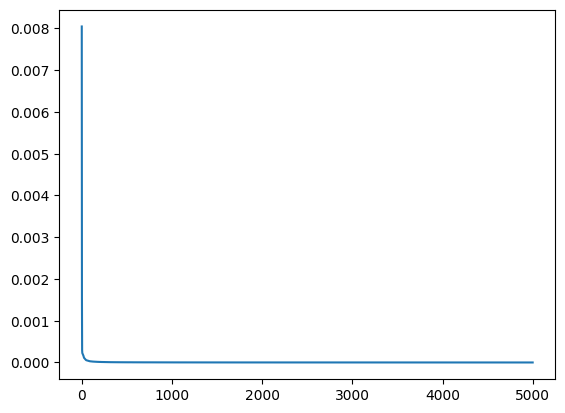

In [ ]:
# Plot depicting decay of loss along epochs:
#avg_loss_epoch[100:]
plt.plot(avg_loss_epoch)
plt.show()

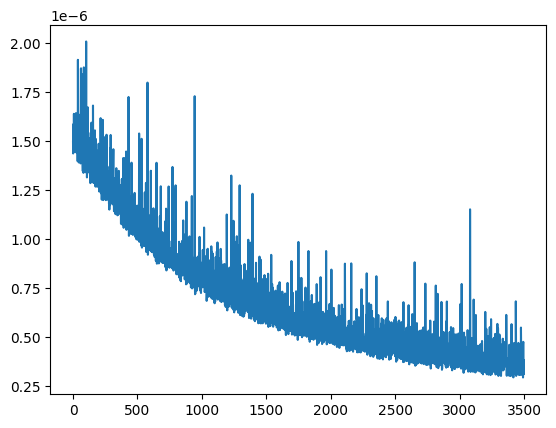

In [ ]:
# Plot depicting decay of loss along epochs:
#
plt.plot(avg_loss_epoch[1500:])
plt.show()

In [ ]:
# @title
print("\nErrors Autoencoder Training:")
print("This is measuring the quality of the autoencoder, measuring the difference between input and its respective reconstructed input.")
print("Error calculation is performed with the normalized data in the interval [0,1].")
#error_point_train = error_fct(dados_aleatorio, reconstructed_data)
error_L1, error_L2, error_Linf = error_fct(uNT, reconstructed_data)


Errors Autoencoder Training:
This is measuring the quality of the autoencoder, measuring the difference between input and its respective reconstructed input.
Error calculation is performed with the normalized data in the interval [0,1].
Vector error L1 is:  0.003624009794940623
Vector error L2 is:  0.0007044719643305282
Vector error L_infinity is:  0.0027157763455170052


In [ ]:
fct5 = lambda x: x.detach().numpy()
# Adjusting format/type of rec_data to numpy format with same dimensions as original_data:
r2 = list(map(fct5, reconstructed_data))
rec_data_stacked_2 = np.stack(r2, axis=1)
rec_data_2 = rec_data_stacked_2[0]
#print(rec_data_2.shape)
#output_ab = output_01 * (b - a) + a,
rec_data_unnormal = rec_data_2 * (max_uN - min_uN) + min_uN
print(rec_data_unnormal.shape)

(1074, 270)


In [ ]:
#rec_data_unnormal.min()
print("The Autoencoder approximation the the full order solution u_h is u_h_AE")
u_h_AE = np.matmul(V,np.transpose(rec_data_unnormal))
print("Shape of u_h_AE is: ", u_h_AE.shape)
print("Shape of u_pod is: ", u_pod.shape)
diff_upod_uhAE = (u_pod - u_h_AE)
print("Shape of the difference u_pod and u_h_AE is: ", diff_upod_uhAE.shape)
print("Max. absolute difference in any point is: ", np.max(np.abs(diff_upod_uhAE)))
print("Min. absolute difference in any point is: ", np.min(np.abs(diff_upod_uhAE)))
print("Average absolute difference in any point is: ", np.mean(np.abs(diff_upod_uhAE)))

The Autoencoder approximation the the full order solution u_h is u_h_AE
Shape of u_h_AE is:  (70801, 1074)
Shape of u_pod is:  (70801, 1074)
Shape of the difference u_pod and u_h_AE is:  (70801, 1074)
Max. absolute difference in any point is:  0.20217326452991857
Min. absolute difference in any point is:  1.6082093989844282e-11
Average absolute difference in any point is:  0.0015947403065539566


In [ ]:
dif = diff_upod_uhAE
dif_abs = np.abs(dif)
dif_flat = dif_abs.flatten()
dif_sort = np.sort(dif_flat)

In [ ]:
import pandas as pd
dif_sort_df = pd.DataFrame(data = dif_sort)
threshold = 5e-2
tth = dif_sort_df[0].loc[lambda x : x >= threshold]
perc_above_threshold = (1 - (tth.size / dif_sort_df.size)) * 100
print(round(perc_above_threshold,5), "% of points have error smaller than the threshold of ", round(threshold,5))

99.82096 % of points have error smaller than the threshold of  0.05


In [ ]:
threshold = 1e-2
tth = dif_sort_df[0].loc[lambda x : x >= threshold]
perc_above_threshold = (1 - (tth.size / dif_sort_df.size)) * 100
print(round(perc_above_threshold,5), "% of points have error smaller than the threshold of ", round(threshold,5))

95.61593 % of points have error smaller than the threshold of  0.01


In [ ]:
def hist(data, bins, title, labels, range = None):
  fig = plt.figure(figsize=(15, 8))
  ax = plt.axes()
  plt.ylabel("Proportion")
  #values, base, _ = plt.hist( data  , bins = bins, normed=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
  values, base, _ = plt.hist( data  , bins = bins, alpha = 0.5, color = "green", range = range, label = "Histogram")
  ax_bis = ax.twinx()
  values = np.append(values,0)
  ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
  plt.xlabel(labels)
  plt.ylabel("Proportion")
  plt.title(title)
  ax_bis.legend();
  ax.legend();

  #plt.grid()
  plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

  plt.show()
  return

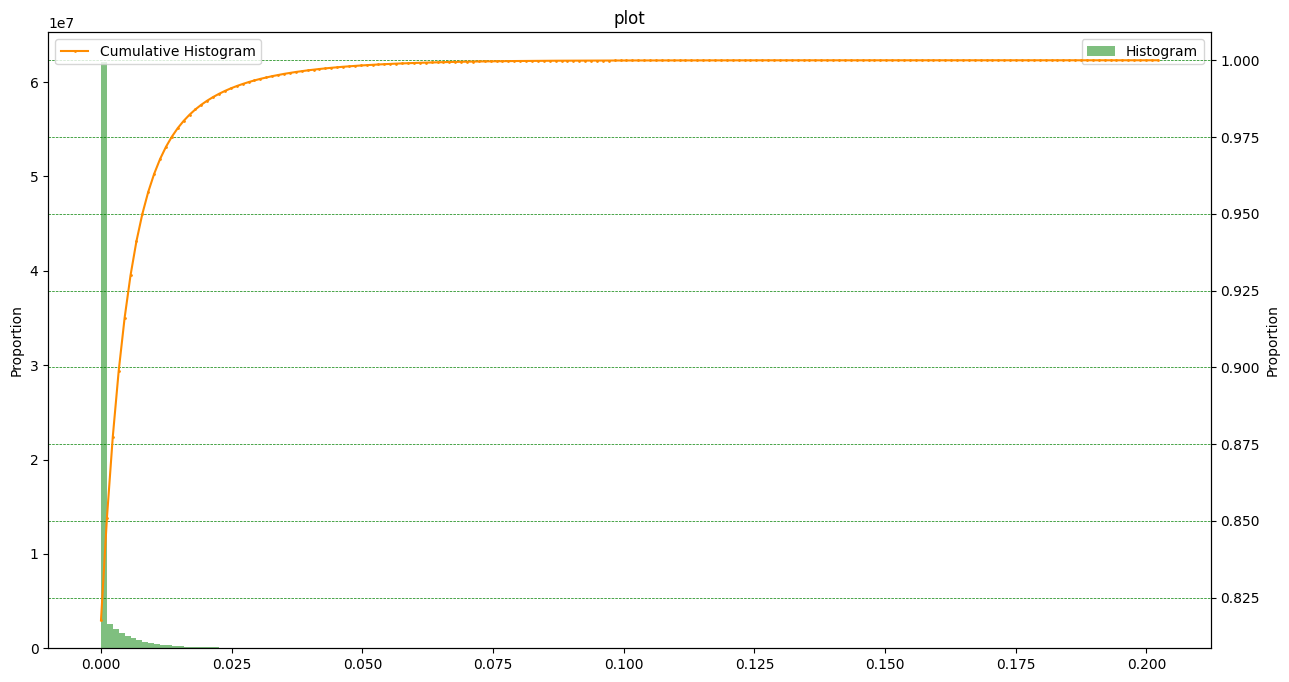

In [ ]:
hist(data = dif_sort, bins = 179, title = 'plot', labels = 'titulo_label')

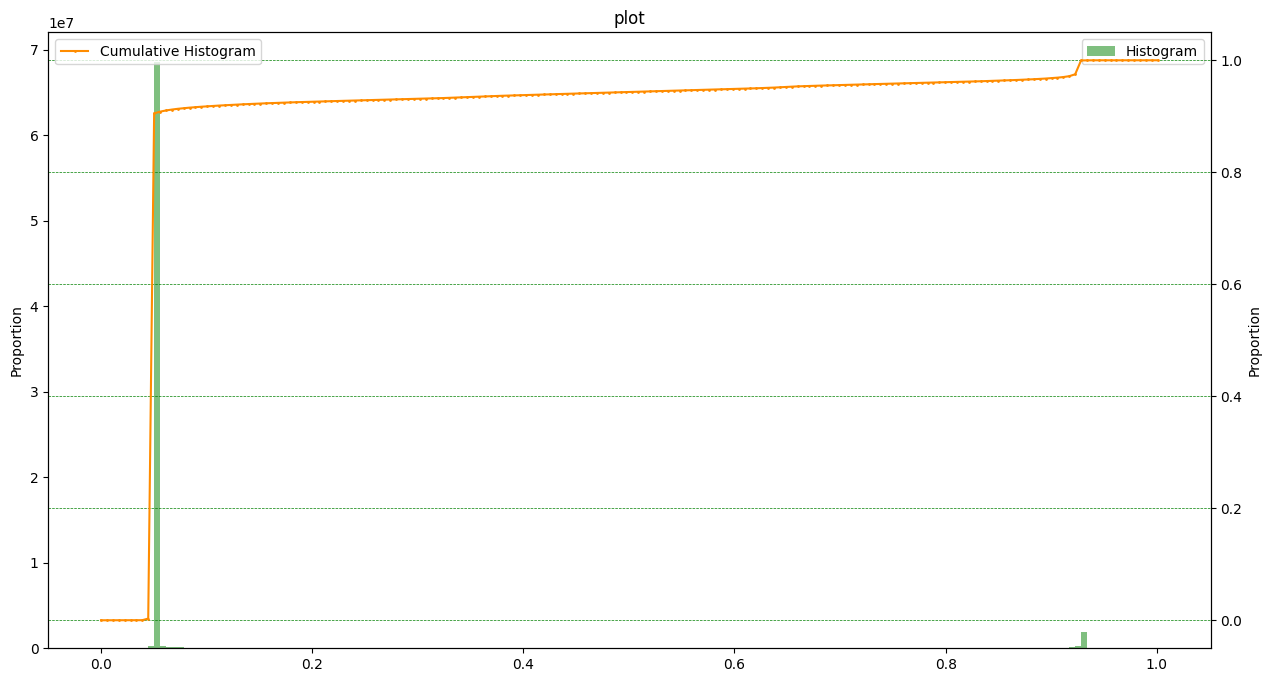

In [ ]:
hist(data = u_pod.flatten(), bins = 179, title = 'plot', labels = 'titulo_label')

In [ ]:
u_pod.max()
# svd nao garante que reconstrucao fica no intervalo [0,1].

1.0008790556843674

In [ ]:
print("Calculating Errors:")
print("Error AE - as equation 5 paper:")

norm_u_pod_L1 = np.linalg.norm(u_pod, ord=1)
error_AE_L1 = ( np.linalg.norm(diff_upod_uhAE, ord=1) ) / norm_u_pod_L1
print("Matrix error L1 is: ", error_AE_L1.round(5))

norm_u_pod_L2 = np.linalg.norm(u_pod, ord=2)
error_AE_L2 = ( np.linalg.norm(diff_upod_uhAE, ord=2) ) / norm_u_pod_L2
print("Matrix error L2 is: ", error_AE_L2.round(5))

# Error for matrix norm:
#norm_u_pod_Linf = np.linalg.norm(u_pod, np.inf)
#error_AE_Linf = ( np.linalg.norm(diff_upod_uhAE, ord='inf') ) / norm_u_pod_Linf
#print("Matrix error L_infinity is: ", error_AE_Linf.round(5))

Calculating Errors:
Error AE - as equation 5 paper:
Matrix error L1 is:  0.03516
Matrix error L2 is:  0.01336


In [ ]:
# Passo 5 - Regressão:
# Step 5 - Regression:

In [ ]:
# Passo 5.1.1 - Construção X_train da Regressão
# Step 5.1.1 - Construction of X_train for Regression

#import numpy as np
len_temporal = S_val.shape[1]
Nmu = [0, 2, 4, 6, 8, 10]
Nt = [x+1 for x in range(len_temporal)]

X_train = np.array([(a, b) for a in Nmu for b in Nt])
# still to normalize - done ahead!

In [ ]:
# Passo 5.1.2 - Construção y_train da Regressão
# Step 5.1.2 - Construction of y_train for Regression

# Preparing y_train:
uN_encoded_tensor = model_AE.encoder(uNT_tensor) # uNT_tensor is normalized but output of encoder not.
uN_encoded_tensor.shape

fct7 = lambda x: x.detach().numpy()
# Adjusting format/type of rec_data to numpy format with same dimensions as original_data:
r3 = list(map(fct7, uN_encoded_tensor))
uN_encoded_np = np.stack(r3, axis=0)
y_train = uN_encoded_np
# still to normalize - done ahead!

In [ ]:
# Passo 5.2.1 - Normalização X_train
# Step 5.2.1 - Normalization X_train

from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

X_train_minmax = min_max_scaler.fit_transform(X_train)

# Confirming normalization of X_train:
print(X_train_minmax.min())
print(X_train_minmax.max())

0.0
1.0


In [ ]:
# Confirming order of error of successive application of scaler and its inverse:
X2 = min_max_scaler.inverse_transform(X_train_minmax)
print(np.max(X2 - X_train))

1.4210854715202004e-14


In [ ]:
# Passo 5.2.2 - Normalização y_train
# Step 5.2.2 - Normalization y_train

y_train_min = y_train.min()
y_train_max = y_train.max()
y_train_norm = (y_train - y_train_min) / (y_train_max - y_train_min)

# Confirming normalization of y_train:
print(y_train_norm.min())
print(y_train_norm.max())

print(y_train_norm.shape)

0.0
1.0
(1074, 16)


In [ ]:
# Passo 5.3 - Definição Classe Dados para Rede Neural (Requisito PyTorch)
# Step 5.3 - Definition Data Class for the Neural Network (PyTorch´s requirement)

class MorTurbiDatasetPODDL(torch.utils.data.Dataset):
  # features in cols [0,11], poverty in [12], price in [13]

  def __init__(self, X, y): # X, y are of numpy type.
    #all_xy = np.loadtxt(src_file, usecols=range(0,14), delimiter="\t", comments="#", dtype=np.float32)
    X_ = X
    y_ = y

    # !!! specify torch 32 ???????????????????????????????????????
    self.x_data = torch.tensor(X_, dtype= torch.float32)#.to(device)
    self.y_data = torch.tensor(y_, dtype= torch.float32)#.to(device)

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx):
    preds = self.x_data[idx]
    latent_conc = self.y_data[idx]
    return (preds, latent_conc)  # as a tuple

In [ ]:
# Passo 5.4 - Instanciação da Classe de dados para a Rede Neural e definição tamanho batch.
# Step 5.4 - Instantiation of Data Class for the neural Network and batch size definition.
b_size_reg_svd = 6
train_ds = MorTurbiDatasetPODDL(X = X_train_minmax, y= y_train_norm)
train_ldr = torch.utils.data.DataLoader(dataset = train_ds, batch_size= b_size_reg_svd, shuffle=False)

In [ ]:
# Passo 5.5 - Definição Classe que constrói a Rede Neural para a Regressão.
# Step 5.5 - Definition of the Class constucting the Neural Network for the Regression.

l1 = 2 # number of columns of X0 (parameter and time_point)  # pick from X_train
l2 =  y_train.shape[1] # dimension of the vector trying to be predicted = size of latent space. # pick from y_train

# Autoencoder class
class NN_regressionPODDL(torch.nn.Module):
  def __init__(self):
      super().__init__()

      self.reg = torch.nn.Sequential(
                            torch.nn.Linear(l1, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            torch.nn.Linear(50, 50),
                            torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            #torch.nn.Linear(50, 50),
                            #torch.nn.Sigmoid(),
                            torch.nn.Linear(50, l2),
                            torch.nn.Sigmoid(),
                            )


  def forward(self, x):
      estimated = self.reg(x)
      return estimated

In [ ]:
# Passo 5.6 - Instanciação Classe Rede Neural e definição parâmetros do processo de Treino.
# Step 5.6 - Instantiation of the class for the Neural network and definition of parameters related to the training process.

lr_reg = 5.0e-3 # learning rate (fixed one if no LR scheduler, initial one in case of use of scheduler)

loss_func_reg =  torch.nn.MSELoss() #torch.nn.L1Loss()  # mean avg error torch.nn.MSELoss()
#loss_function = torch.nn.SmoothL1Loss(beta = 2.0)#torch.nn.HuberLoss(delta=1e-1)#torch.nn.SmoothL1Loss(beta = 0.1)#torch.nn.HuberLoss(delta=1e-3)#torch.nn.SmoothL1Loss()# torch.nn.HuberLoss()#torch.nn.HuberLoss(reduction='mean', delta=1.0) #torch.nn.MSELoss()
# torch.nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

# Number of epochs:
n_epochs_reg = 2000 #1500 #20000

# Definition of weights initialization:
def init_weights_reg(m):
    if isinstance(m, torch.nn.Linear):
      torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='leaky_relu')
      #torch.nn.init.xavier_uniform(m.weight)
      #m.bias.data.fill_(0.01)

# Starting the model
model_reg = NN_regressionPODDL() # instantiation of Regression Model

model_reg.apply(init_weights_reg) # initialize weights with He normal initialiser.

# Definition of Optimizer:
optimizer_reg = torch.optim.Adam(
    model_reg.parameters(),
    lr=lr_reg,
    #betas=(0.9, 0.999),
    #eps = 1e-08,
    #weight_decay = 1e-8,
    )


# Choice of schedulers for adaptive Learning Rate:
#scheduler_reg = torch.optim.lr_scheduler.ExponentialLR(optimizer_reg, gamma=0.85)
scheduler_reg = torch.optim.lr_scheduler.StepLR(optimizer_reg, step_size=50, gamma=0.75)
#scheduler_reg = torch.optim.lr_scheduler.MultiStepLR(optimizer_reg, milestones=[20,50,100,150,200,300,500,1000], gamma=0.55)

In [ ]:
# Passo 5.7 - Treino da Rede Neural - Regressão.
# Step 5.7 - Training Process for the Neural Network - Regression.

from tqdm.notebook import trange
start = time.time()
print("Starting time counting \n")

epochs = n_epochs_reg

outputs_reg = []
reg_avg_loss_by_epoch = []

# Running loop of epochs:
for epoch in trange(epochs):
#for epoch in range(epochs):
    time_epoch = time.time()
    losses_batches_per_epoch = []

    for k, image in enumerate(train_ldr):

          c = k % 50
          reconstructed = model_reg(image[0])
          loss_reg = loss_func_reg(reconstructed, image[1])

          optimizer_reg.zero_grad()
          loss_reg.backward()
          optimizer_reg.step()

          losses_batches_per_epoch.append(loss_reg)

    # Learning rate scheduler:
    before_lr = optimizer_reg.param_groups[0]["lr"]

    #m_epoch = epoch % 50
    #if m_epoch == 0:
    #  scheduler_reg.step()

    scheduler_reg.step()
    after_lr = optimizer_reg.param_groups[0]["lr"]

    temp_loss_batch = losses_batches_per_epoch

    item_fct9 = lambda x: x.item()
    l_loss = np.array(list(map(item_fct9, temp_loss_batch)))
    temp_avg_loss_epoch = l_loss.mean()
    print('Average loss at epoch ', epoch, ' was ', round(temp_avg_loss_epoch, 7), "and it took ", round(time.time() - time_epoch,3), " seconds. ", "LR %.7f -> %.7f" % (before_lr, after_lr), " .") #, "\n")  " LR: ", before_lr, " to ", after_lr
    # "Epoch %d: SGD lr %.4f -> %.4f" % (epoch, before_lr, after_lr)
    reg_avg_loss_by_epoch.append(temp_avg_loss_epoch)

    outputs_reg.append((epochs, image, reconstructed))


# Time counting:
end = time.time()
total_time = end - start
print("\nLoop with ", epochs, "epochs took ", round(total_time,2) , " seconds.")
print("An average of ", round(total_time/epochs,4), " seconds per epoch.")

Starting time counting 



  0%|          | 0/2000 [00:00<?, ?it/s]

Average loss at epoch  0  was  0.010528 and it took  0.367  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  1  was  0.0070773 and it took  0.375  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  2  was  0.0066194 and it took  0.387  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  3  was  0.0064006 and it took  0.356  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  4  was  0.0063027 and it took  0.352  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  5  was  0.0062696 and it took  0.36  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  6  was  0.0062584 and it took  0.346  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  7  was  0.0062521 and it took  0.343  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  8  was  0.0062289 and it took  0.447  seconds.  LR 0.0050000 -> 0.0050000  .
Average loss at epoch  9  was  0.006265 and it took  0.364  seconds.  LR 0.0050000 -> 0.0050000  .
Ave

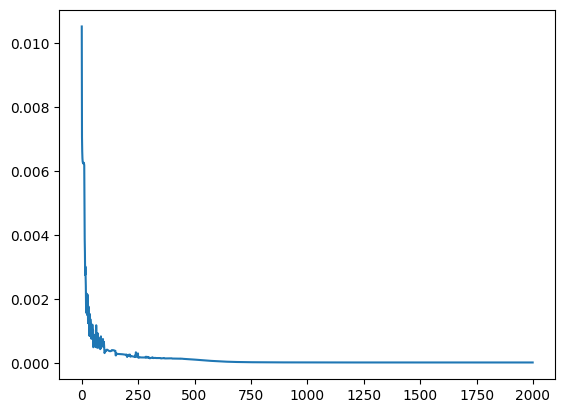

In [ ]:
# Plot depicting decay of loss along epochs:
plt.plot(reg_avg_loss_by_epoch[0:])
plt.show()

In [ ]:
# Predição a partir do modelo de Regressão treinado.
# Prediction from trained regression model.


In [ ]:
# Passo 6.0 - A fazer - Carregar Modelo
# Step 6.0 - TBD - Load Model

In [ ]:
# Passo 6.1 - Construção X_val
# Step 6.1 - Construction X_val

# Fabricating X_val for evaluating regression predition:
Nval = [5]
X_val = np.array([(a,b) for a in Nval for b in Nt])
# still to normalize

In [ ]:
# Passo 6.2 - Normalização de X_val segundo 4.2.1
# Step 6.2 - Normalization of X_val according to 4.2.1

X_val_minmax = min_max_scaler.transform(X_val)

print(X_val_minmax.min())
print(X_val_minmax.max())

0.0
0.9999999999999999


In [ ]:
# Passo 6.3 - Cálculo predição do modelo sobre X_val_minmax.
# Step 6.3 - Evaluation of the model over X_val_minmax.

# Transforming X_val_minmax in Tensor format to be used by pytorch model
X_val_minmax_tensor = torch.tensor(X_val_minmax, dtype= torch.float32)

y_val_norm_pred_tensor = model_reg(X_val_minmax_tensor) # output is a tensor
print(y_val_norm_pred_tensor.shape)

# converts tensor to numpy:
fct1 = lambda x: x.detach().numpy()
# Adjusting format/type of rec_data to numpy format with same dimensions as original_data:
y_val_norm_pred_np = np.stack(list(map(fct1, y_val_norm_pred_tensor)), axis=1)
print(type(y_val_norm_pred_np))
print(y_val_norm_pred_np.shape)

print(y_val_norm_pred_np.min())
print(y_val_norm_pred_np.max())

torch.Size([179, 16])
<class 'numpy.ndarray'>
(16, 179)
0.01857792
0.97784483


In [ ]:
# Passo 6.4 - Inversão da normalização feita em 5.2.2.
# Step 6.4 - Inversion of Normalization performed in 5.2.2

y_val_pred_np = y_val_norm_pred_np * (y_train_max - y_train_min) + y_train_min
print(y_val_pred_np.min())
print(y_val_pred_np.max())

-4.545929
3.2674127


In [ ]:
# Passo 6.4 - Aplicação Decoder de forma a voltar para espaço dimensão base POD.
# Step 6.4 - Apply decoder such that data returns to dimensional space same as POD basis.

# converter para tensor:
y_val_pred_tensor = torch.tensor(np.transpose(y_val_pred_np), dtype= torch.float32)

# aplicar decoder:
y_val_podbasis_tensor = model_AE.decoder(y_val_pred_tensor)

# Retornar para numpy (Ja realiza transposta):
y_val_podbasis_np = np.stack(list(map(fct1, y_val_podbasis_tensor)), axis=1)
print(type(y_val_podbasis_np))
print(y_val_podbasis_np.shape)

# Inverter normalizacao pre-autoencoder:
y_val_podbasis_np_renorm = y_val_podbasis_np * (max_uN - min_uN) + min_uN
print(type(y_val_podbasis_np_renorm))
print(y_val_podbasis_np_renorm.shape)
print(y_val_podbasis_np_renorm.min())
print(y_val_podbasis_np_renorm.max())

# Aplicar V e voltar ao espaço original dos dados:
y_val_orig_basis_np = np.matmul(V,y_val_podbasis_np_renorm)
print(y_val_orig_basis_np.shape)
print(y_val_orig_basis_np.min())
print(y_val_orig_basis_np.max())

# Inverter normalização pre-svd:
y_val_orig_basis_renorm_np = y_val_orig_basis_np * (max_Strain - min_Strain) + min_Strain
print(y_val_orig_basis_renorm_np.shape)
print(y_val_orig_basis_renorm_np.min())
print(y_val_orig_basis_renorm_np.max())



<class 'numpy.ndarray'>
(270, 179)
<class 'numpy.ndarray'>
(270, 179)
-47.4733
30.088291
(70801, 179)
-0.06655327815556042
1.038803813074268
(70801, 179)
-0.1342818895707853
1.1242159251775585


In [ ]:
# Passo 8 - Cálculo erros l2 e linf entre predição regressão POD-DL e valor real
# Step 8 - Evaluation of l2 and linf errors between prediction based on POD-DL regression and real value.

# check both vectors have same dimensions # Numpy may calculate difference even if dimension do no match
print(y_val_orig_basis_renorm_np.shape)
print(S_val.shape)



(70801, 179)
(70801, 179)


In [ ]:
import pickle

# Save the predicted numpy array with Pickle
with open("/content/drive/MyDrive/turbi/" + "pod_" + str(N) + "_DL_" + str(l2) + ".pkl", 'wb') as f:
    pickle.dump(y_val_orig_basis_renorm_np, f)

# Save the original numpy array with Pickle
#with open("/content/drive/MyDrive/turbi/" + "S_val.pkl", 'wb') as f:
#    pickle.dump(S_val, f)

In [3]:
import pickle
import joblib
S_val = joblib.load("/content/drive/MyDrive/turbi/" + "snapshots/" + "snapshots_theta_5_5_to_895" + ".pkl")
# open a file, where you stored the pickled data
file = open("/content/drive/MyDrive/turbi/" + "pod_" + str(270) + "_DL_16.pkl", 'rb')

# dump information to that file
y_val_pred_phys = pickle.load(file)

In [5]:
diff_pred_true = y_val_pred_phys - S_val
print(diff_pred_true.shape)
print(diff_pred_true.min())
print(diff_pred_true.max())

(70801, 179)
-0.26643842641677007
0.4080111327103992


In [6]:
# l2 and linfinity norms of error:
from numpy import linalg as LA
nm_2 = LA.norm(diff_pred_true, ord = 2, axis=0, keepdims = True)
nm_inf = LA.norm(diff_pred_true, ord = np.inf, axis=0, keepdims = True)
print(nm_2.shape)
print(nm_inf.shape)
print(nm_2.min())
print(nm_2.max())
print(nm_inf.min())
print(nm_inf.max())

(1, 179)
(1, 179)
1.1972552719585061
4.822470184917981
0.04537468457094174
0.4080111327103992


In [ ]:
# Plot of absolute relative error:
#plt.plot(np.transpose(nm_2)/np.transpose(LA.norm(S_val, ord = 2, axis=0, keepdims = True)))
#plt.show()

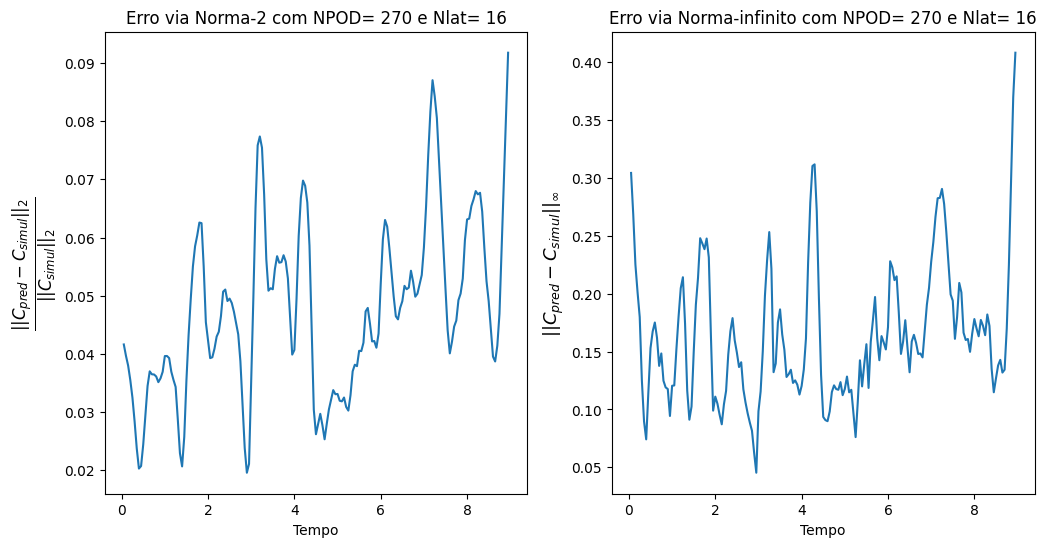

In [9]:
# Plot of absolute relative error:

# data
e_r_p_2 = (np.transpose(nm_2)/np.transpose(LA.norm(S_val, ord = 2, axis=0, keepdims = True)) )

# axis definition:
x_erp = np.arange(0.05, 9.0, 0.05)

# Plot curves:
#fig, (ax1,ax2) = plt.subplots(1,2)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))

# First plot - Norma 2 - Erro relativo absoluto percentual
ax1.plot(x_erp,e_r_p_2)

N=270
l2=16
#formatting axes
tit_graph = "Erro via Norma-2 com NPOD= " + str(N) + " e Nlat= " + str(l2)
ax1.set_title(tit_graph)
ax1.set_xlabel("Tempo")
ax1.set_ylabel(r'$\frac{||C_{pred} - C_{simul}||_2}{||C_{simul}||_2}$', fontsize=17)
#ax1.set_xlim(0,15)
#ax1.set_ylim(-0.9, 0.9)
#ax1.legend(["",""])

# Second plot - Norma Infinito - Erro
ax2.plot(x_erp,np.transpose(nm_inf))
ax2.set_title("Erro via Norma-infinito com NPOD= " + str(N) + " e Nlat= " + str(l2))
ax2.set_xlabel("Tempo")
ax2.set_ylabel(r'$||C_{pred} - C_{simul}||_\infty$', fontsize=13)

# Displaying the figure
plt.show()


In [10]:
import pandas as pd

e2_series = pd.Series(e_r_p_2.flatten(), name='svd_270_DL_16_l2')
einf_series = pd.Series(nm_inf.flatten(), name='svd_270_DL_16_linf')
time_series = pd.Series(x_erp, name='times')

# Create a DataFrame
df = pd.concat([time_series, e2_series, einf_series],axis=1)


In [12]:
# Write the DataFrame to a CSV file
df.to_csv("/content/drive/MyDrive/turbi/" + "svd_270_DL_16_errors.csv", index=False)  # index=False argument is used to prevent pandas from writing row indices into the CSV file

In [ ]:
# Plot l2 error scaled by number of points:
#plt.plot(np.transpose(nm_2)/diff_pred_true.shape[0])
#plt.show()

In [ ]:
# Plot linfinity error:
#plt.plot(np.transpose(nm_inf))
#plt.show()

In [ ]:
# Function to construct histogram:
def hist(data, bins, title, labels, range = None):
  fig = plt.figure(figsize=(15, 8))
  ax = plt.axes()
  plt.ylabel("Proportion")
  #values, base, _ = plt.hist( data  , bins = bins, normed=True, alpha = 0.5, color = "green", range = range, label = "Histogram")
  values, base, _ = plt.hist( data  , bins = bins, alpha = 0.5, color = "green", range = range, label = "Histogram")
  ax_bis = ax.twinx()
  values = np.append(values,0)
  ax_bis.plot( base, np.cumsum(values)/ np.cumsum(values)[-1], color='darkorange', marker='o', linestyle='-', markersize = 1, label = "Cumulative Histogram" )
  plt.xlabel(labels)
  plt.ylabel("Proportion")
  plt.title(title)
  ax_bis.legend();
  ax.legend();

  #plt.grid()
  plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

  plt.show()
  return

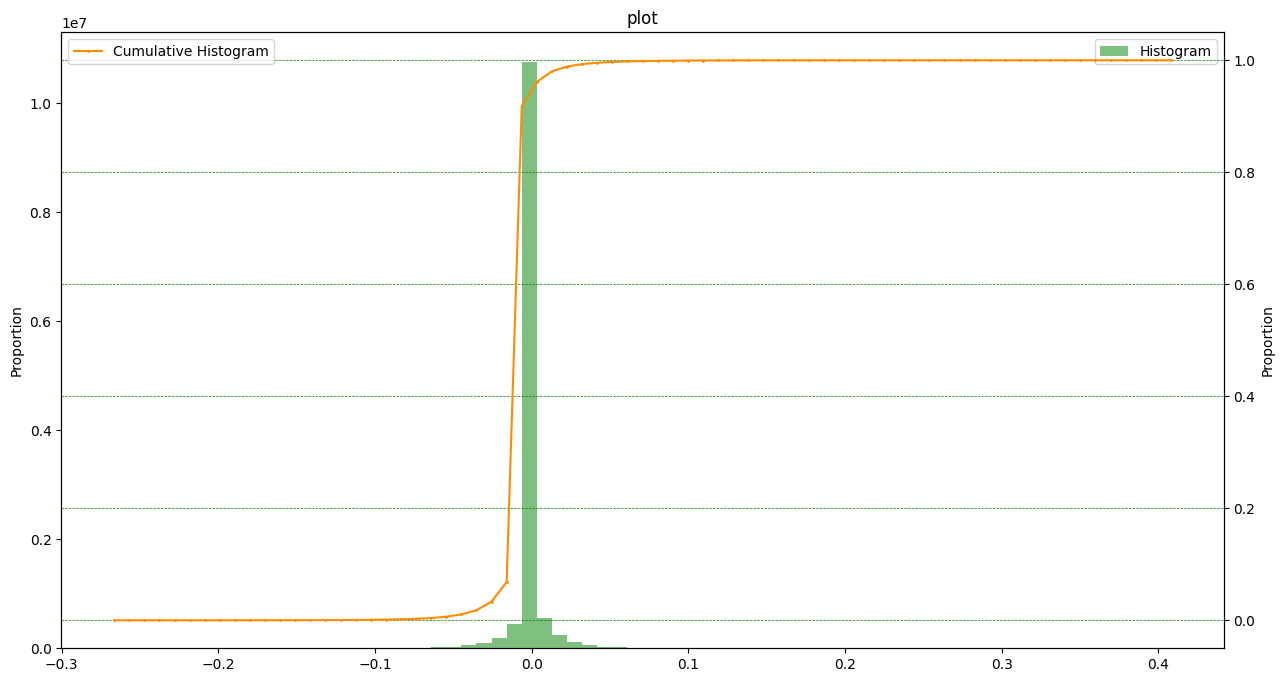

In [ ]:
# Generation of histogram:
hist(data = diff_pred_true.flatten(), bins = 70, title = 'plot', labels = 'titulo_label')